# Data understanding

De gebruikte dataset is “Vestigingen_Gemeente" (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/81575NED/table?ts=1584707583585). 

De CBS data is een csv bestand, dit staat voor comma seperated values of door comma gescheide waarden in het nederlands.
De data bevat de volgende kolomen:
 - `ID` is de unieke waarde voor elke row.
 - `Bedrijfstakken/branches SBI 2008` geeft de waarde weer in welke bedrijfstak/branch de bedrijfen zit.
 - `Perioden` geeft de periode aan waarin de bedrijfstak/branch actief in is.
 - `Regio's` is de regio waarin de behorende bedrijfstak/branch actief in is.
 - `Vestigingen (aantal)` is de aantal vestigingen die binnen die bedrijfstak/branch geteld zijn per regio en per periode.

## Beschrijven van de data

Hieronder staat een beschrijving van de data vanuit de Centraal Bureau Statistieken. Dit wordt telkens door middel van een stukje code weergegeven. 

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from prep import movecol
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, _plot_corr
from statsmodels.tsa.arima_model import ARIMA

pd.set_option('display.max_rows', 50)

# Dataset inlezen
file = "../raw-data/Vestegingen_Gemeente.csv"
postcode_file = "../raw-data/gemeenten-provincie.xlsx"
data_pc = pd.read_excel(postcode_file)
data_vg = pd.read_csv(file, sep=";")

# Dataverkennen door dataframe te openen
data_vg


Bad key "text.kerning_factor" on line 4 in
C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110
...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0
1934,U Extraterritoriale organisaties,2015,Zwolle,0
1935,U Extraterritoriale organisaties,2016,Zwolle,0
1936,U Extraterritoriale organisaties,2017,Zwolle,0


Vervolgens dient er een aantal onderzoeken over de data ingesteld te worden. Er wordt bijvoorbeeld gekeken naar de verschillende waarden in bepaalde kolommen en bij elkaar gegroepeerd.

In [2]:
regios = data_vg["Regio's"].drop_duplicates()
regios

0                     Amsterdam
6                        Arnhem
12                        Assen
18                        Breda
24                    Eindhoven
30                     Enschede
36     's-Gravenhage (gemeente)
42         Groningen (gemeente)
48                      Haarlem
54             's-Hertogenbosch
60                   Leeuwarden
66                       Leiden
72                     Lelystad
78                   Maastricht
84              Middelburg (Z.)
90                    Rotterdam
96                      Tilburg
102          Utrecht (gemeente)
108                      Zwolle
Name: Regio's, dtype: object

In [3]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


In [4]:
# Info over de kolommen
groepeerde_data_vg = data_vg.groupby(["Regio's", "Perioden"]).sum()
info_kolommen_vg = data_vg.info()
info_kolommen_vg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Bedrijfstakken/branches SBI 2008  1938 non-null   object
 1   Perioden                          1938 non-null   int64 
 2   Regio's                           1938 non-null   object
 3   Vestigingen (aantal)              1938 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 60.7+ KB


In [5]:
# Beschrijvende statistieken van de data
beschrijvende_stats_vg = data_vg.describe()
beschrijvende_stats_vg

,Perioden,Vestigingen (aantal)
count,1938.000000,1938.000000
mean,2015.500000,1256.542828
std,1.708266,2690.824443
min,2013.000000,0.000000
25%,2014.000000,66.250000
50%,2015.500000,470.000000
75%,2017.000000,1248.750000
max,2018.000000,36290.000000


In [6]:
# Informatie over de kolomnamen in de Dataframe
data_vg.columns

Index(['Bedrijfstakken/branches SBI 2008', 'Perioden', 'Regio's',
       'Vestigingen (aantal)'],
      dtype='object')

In [7]:
# Controleren op nulwaarden in de dataframe
data_vg.isna().sum()

Bedrijfstakken/branches SBI 2008    0
Perioden                            0
Regio's                             0
Vestigingen (aantal)                0
dtype: int64

## Data exploratie

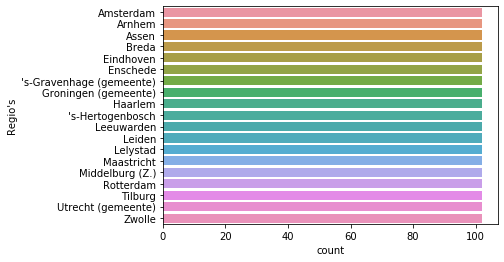

In [8]:
# Het laten zien van hoevaak een regio voorkomt in de dataset.
sb.countplot(y="Regio's", data=data_vg)

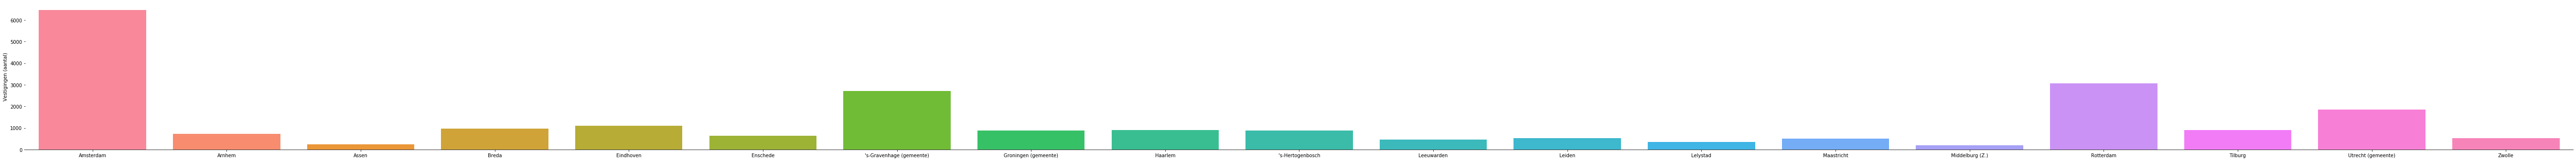

In [9]:
g = sb.catplot(x="Regio's", y="Vestigingen (aantal)",
                data=data_vg, saturation=10,
                kind="bar", ci=None, aspect=15)
(g.set_axis_labels("", "Vestigingen (aantal)")
  .set_titles("{col_name} {col_var}")
  .despine(left=True))

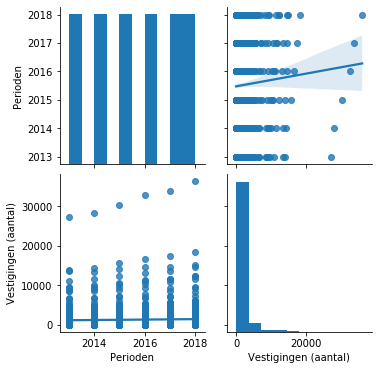

In [10]:
sb.pairplot(data_vg, kind="reg")

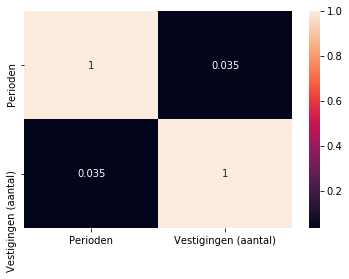

In [11]:
sb.heatmap(data_vg.corr(), annot=True)

### Samenvatting

Er zijn nu 2 datasets:
- `data_vg` is de 'standaard' dataframe met alle kolommen en waardes die compleet zijn.
- `groepeerde_data_vg` is de **gegroepeerde** dataset, gegroepeerd op de kolommen `Regio's` en `Perioden`.

# Data Preparation

Tijdens de analyse van de benodigde data worden de datasets `data_vg` en `groepeerde_data_vg` gebruikt. Van deze dataset wordt de data vanaf het jaar 2013 t/m 2018 gebruikt. De jaren 2019 en 2020 zijn wel beschikbaar, maar nog niet volledig.

Om te bepalen welke data gebruikt dient te worden, wordt er gekeken naar hoe de data aan de data mining goals kan voldoen. De data mining goal is: **Het verhogen van succesvolle woningzoekers die op zoek zijn naar een woonplek**.

De `data_vg` focust zich op het zoeken van mogelijke werkplekken van een woningzoekende in de ideale regio. De user story die beantwoordt dient te worden met de `data_vg` is **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

Ook wordt er een dataframe `data_pc` toegevoegd aan `data_vg`, zodat per regio de plaats, gemeente en provincie wordt weergegeven.

## Select Data

Van `data_vg` worden alle kolommen gebruikt voor het beantwoorden van de user story.

Van `data_pc` wordt een aantal kolommen gebruikt, namelijk:
- `Plaats`.
- `Gemeente`.
- `Provincie`.



In [12]:
data_pc.columns

Index(['Regio's', 'Provincie'], dtype='object')

In [13]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


## Clean Data

In dit onderdeel wordt gekeken welke acties moeten worden ondernomen om de data op te schonen. Er wordt bijvoorbeeld gekeken naar rare waardes, aanpassingen in de records of overige acties.

In [14]:
# Unieke waarden in de verschillende kolommen van data_vg
test = ["Bedrijfstakken/branches SBI 2008", "Perioden", "Regio's", "Vestigingen (aantal)"]
for i in test:
    print(i, data_vg[i].unique())

Bedrijfstakken/branches SBI 2008 ['A Landbouw, bosbouw en visserij' 'B Delfstoffenwinning' 'C Industrie'
 'D Energievoorziening' 'E Waterbedrijven en afvalbeheer'
 'F Bouwnijverheid' 'G Handel' 'H Vervoer en opslag' 'I Horeca'
 'J Informatie en communicatie' 'K Financiële dienstverlening'
 'L Verhuur en handel van onroerend goed'
 'M Specialistische zakelijke diensten'
 'N Verhuur en overige zakelijke diensten' 'R Cultuur, sport en recreatie'
 'S Overige dienstverlening' 'U Extraterritoriale organisaties']
Perioden [2013 2014 2015 2016 2017 2018]
Regio's ['Amsterdam' 'Arnhem' 'Assen' 'Breda' 'Eindhoven' 'Enschede'
 "'s-Gravenhage (gemeente)" 'Groningen (gemeente)' 'Haarlem'
 "'s-Hertogenbosch" 'Leeuwarden' 'Leiden' 'Lelystad' 'Maastricht'
 'Middelburg (Z.)' 'Rotterdam' 'Tilburg' 'Utrecht (gemeente)' 'Zwolle']
Vestigingen (aantal) [   95   100   105   110   120    50    55    65    75    80   220   215
   225    40    45   150   145   155   175   185   190  1540  1480  1490
  1555  1640

Uit de vorige functie is te herlijden dat:
- `Bedrijfstakken/branches SBI 2008` heeft geen opmerkelijke waarden. Alle records zijn volgens hetzelfde format ingevuld.
- `Perioden` is gereed voor gebruik.
- `Regio's` heeft een aantal dubbele waarden, maar die worden weer gescheiden door de afkorting van de province van de Regio.
- `Vestigingen (aantal)` heeft een opmerkelijke notatie die op basis van vorige functie anders word weergegeven dan in de tabelweergave. De waarden zijn echter correct en hetzelfde, maar met een andere notatie. Het valt op dat er in deze kolom een NaN waarde zit, dat dient aangepast te worden.

In [15]:
# Invullen van de Na/NaN waarden in kolom Vestigingen (aantal) door 0
data_vg2 = data_vg["Vestigingen (aantal)"].fillna(0)
data_vg2

0        95
1       100
2       105
3       105
4       110
       ... 
1933      0
1934      0
1935      0
1936      0
1937      0
Name: Vestigingen (aantal), Length: 1938, dtype: int64

## Construct data

De data uit de twee dataset `data_vg` en `data_pc` worden samengevoegd om verder mee te werken. De nieuwe dataset heet `data_vg_incl_provincie`.

Om de data bruikbaar te maken voor user input in het formulier, wordt een classificatie aangebracht aan het aantal vestigingen. De waarde van deze classificatie zal bepaald worden door de uitkomst van data_vg.describe() uit de data understanding. De klassen zijn:
- `Laag`.
- `Middel`.
- `Hoog`.
- `Geen`.


In [16]:
data_vg_incl_provincie = pd.merge(data_vg, data_pc, left_on="Regio's", right_on="Regio's")
data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal),Provincie
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95,Noord-Holland
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100,Noord-Holland
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105,Noord-Holland
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105,Noord-Holland
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110,Noord-Holland
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0,Overijssel
1934,U Extraterritoriale organisaties,2015,Zwolle,0,Overijssel
1935,U Extraterritoriale organisaties,2016,Zwolle,0,Overijssel
1936,U Extraterritoriale organisaties,2017,Zwolle,0,Overijssel


Vervolgens zullen de nieuwe kolommen goed gesorteerd worden in de dataset.

In [17]:
data_vg_incl_provincie = movecol(data_vg_incl_provincie, cols_to_move=['Provincie'], ref_col="Regio's", place='After')
data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Provincie,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,Noord-Holland,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,Noord-Holland,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,Noord-Holland,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,Noord-Holland,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,Noord-Holland,110
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,Overijssel,0
1934,U Extraterritoriale organisaties,2015,Zwolle,Overijssel,0
1935,U Extraterritoriale organisaties,2016,Zwolle,Overijssel,0
1936,U Extraterritoriale organisaties,2017,Zwolle,Overijssel,0


In [94]:
np.set_printoptions(threshold=np.inf)

min_max_scaler = preprocessing.MinMaxScaler()

aantal_vestigingen_minmax = min_max_scaler.fit_transform(data_vg_incl_provincie[["Vestigingen (aantal)"]])
data_vg_incl_provincie["Aantal_vestigingen_genormaliseerd"] = aantal_vestigingen_minmax

data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Provincie,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,Noord-Holland,95,0.002618
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,Noord-Holland,100,0.002756
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,Noord-Holland,105,0.002893
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,Noord-Holland,105,0.002893
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,Noord-Holland,110,0.003031
...,...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,Overijssel,0,0.000000
1934,U Extraterritoriale organisaties,2015,Zwolle,Overijssel,0,0.000000
1935,U Extraterritoriale organisaties,2016,Zwolle,Overijssel,0,0.000000
1936,U Extraterritoriale organisaties,2017,Zwolle,Overijssel,0,0.000000


De nieuwe dataset `werkgelegenheid_groupby` wordt gegroepeerd op `Provincie`, `Regio's`, `Perioden` en `Bedrijfstakken/branches SBI 2008`. Dit geeft een mooi overzicht

In [69]:
werkgelegenheid_groupby = data_vg_incl_provincie.groupby(['Provincie',"Regio's", 'Perioden', 'Bedrijfstakken/branches SBI 2008']).sum()
werkgelegenheid_groupby

Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65   
                                B Delfstoffenwinning                                        5   
                                C Industrie                                               160   
                                D Energievoorziening                                        0   
                                E Waterbedrijven en afvalbeheer                            10   
...                                                                                       ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655   
                                N Verhuur en overige zakelijke diensten                  2910   
                                R Cultuur, sport en recreatie                            5440   
                                S Overige dienstverlening                                3330   
                                U Extraterritoriale organisaties                            0   

                                                                         Aantal_vestigingen_genormaliseerd  
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                            
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                                   0.001791  
                                B Delfstoffenwinning                                              0.000138  
                                C Industrie                                                       0.004409  
                                D Energievoorziening                                              0.000000  
                                E Waterbedrijven en afvalbeheer                                   0.000276  
...                                                                                                    ...  
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                              0.403830  
                                N Verhuur en overige zakelijke diensten                           0.080187  
                                R Cultuur, sport en recreatie                                     0.149904  
                                S Overige dienstverlening                                         0.091761  
                                U Extraterritoriale organisaties                                  0.000000  

[1938 rows x 2 columns]

Vervolgens wordt er een normalisatietechniek toegepast op `Vestigingen (aantal)`, zodat deze waarden vergeleken kunnen worden met andere waarden van andere datasets.

In [71]:
werkgelegenheid_groupby.describe()

,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd
count,1938.000000,1938.000000
mean,1256.542828,0.034625
std,2690.824443,0.074148
min,0.000000,0.000000
25%,66.250000,0.001826
50%,470.000000,0.012951
75%,1248.750000,0.034410
max,36290.000000,1.000000


De data van werkgelegenheid_groupby wordt gecategoriseerd op een `Geen`, `Laag`, `Middel`, `Middel-Hoog` of `Hoog` aantal vestigingen in een bepaalde branche.

In [95]:
#werkgelegenheid_groupby.drop(columns=["Klasse vestigingsaantal"])
vestigingen = werkgelegenheid_groupby["Aantal_vestigingen_genormaliseerd"]

# Gebruik de aantallen die bij vg_data.describe() staan
werk_25 = vestigingen.quantile(q=.25)
werk_50 = vestigingen.quantile(q=.5)
werk_75 = vestigingen.quantile(q=.75)

print(werk_25, werk_50, werk_75)

# Gebruik de aantallen die bij vg_data.describe() staan
m1 = np.logical_and(vestigingen < werk_25, vestigingen != 0)
m2 = np.logical_and(vestigingen >  werk_25, vestigingen < werk_50)
m3 = np.logical_and(vestigingen >  werk_50, vestigingen < werk_75)
m4 = vestigingen > werk_75

werkgelegenheid_groupby["Vestigingen Klasse"] = np.select([m1,m2,m3,m4], ['Laag','Middel','Middel-Hoog','Hoog'], default='Geen')

werkgelegenheid_groupby

0.001825571782860292 0.012951226233122072 0.0344103058693855


Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65   
                                B Delfstoffenwinning                                        5   
                                C Industrie                                               160   
                                D Energievoorziening                                        0   
                                E Waterbedrijven en afvalbeheer                            10   
...                                                                                       ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655   
                                N Verhuur en overige zakelijke diensten                  2910   
                                R Cultuur, sport en recreatie                            5440   
                                S Overige dienstverlening                                3330   
                                U Extraterritoriale organisaties                            0   

                                                                         Aantal_vestigingen_genormaliseerd  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                             
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                                   0.001791   
                                B Delfstoffenwinning                                              0.000138   
                                C Industrie                                                       0.004409   
                                D Energievoorziening                                              0.000000   
                                E Waterbedrijven en afvalbeheer                                   0.000276   
...                                                                                                    ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                              0.403830   
                                N Verhuur en overige zakelijke diensten                           0.080187   
                                R Cultuur, sport en recreatie                                     0.149904   
                                S Overige dienstverlening                                         0.091761   
                                U Extraterritoriale organisaties                                  0.000000   

                                                                        Vestigingen Klasse  
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                            
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                       Laag  
                                B Delfstoffenwinning                                  Laag  
                                C Industrie                                         Middel  
                                D Energievoorziening                                  Geen  
                                E Waterbedrijven en afvalbeheer                       Laag  
...                                                                                    ...  
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                  Hoog  
                                N Verhuur en overige zakelijke diensten               Hoog  
                                R Cultuur, sport en recreatie                         Hoog  
                                S Overige dienstverlening                             Hoog  
                                U Extraterritoriale organisaties                      Geen  

[1938 rows x 3 columns]

Om de dataset in Flask te kunnen gebruiken, nemen we de gegroepeerde dataset over en maken we een nieuwe index aan. Hierdoor zijn `Provincie`, `Regio's`, `Perioden` en `Bedrijfstakken/branches SBI 2008` weer normale kolommen.

In [73]:
werkgelegenheid_groupby_index = werkgelegenheid_groupby.reset_index()
werkgelegenheid_groupby_index

,Provincie,Regio's,Perioden,Bedrijfstakken/branches SBI 2008,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd,Vestigingen Klasse
0,Drenthe,Assen,2013,"A Landbouw, bosbouw en visserij",65,0.001791,Laag
1,Drenthe,Assen,2013,B Delfstoffenwinning,5,0.000138,Laag
2,Drenthe,Assen,2013,C Industrie,160,0.004409,Middel
3,Drenthe,Assen,2013,D Energievoorziening,0,0.000000,Geen
4,Drenthe,Assen,2013,E Waterbedrijven en afvalbeheer,10,0.000276,Laag
...,...,...,...,...,...,...,...
1933,Zuid-Holland,Rotterdam,2018,M Specialistische zakelijke diensten,14655,0.403830,Hoog
1934,Zuid-Holland,Rotterdam,2018,N Verhuur en overige zakelijke diensten,2910,0.080187,Hoog
1935,Zuid-Holland,Rotterdam,2018,"R Cultuur, sport en recreatie",5440,0.149904,Hoog
1936,Zuid-Holland,Rotterdam,2018,S Overige dienstverlening,3330,0.091761,Hoog


Vervolgens wordt er in de dataset `werkgelegenheid_groupby_index` de bedrijfstakken kolom gesplitst in een `bedrijfstak_code` en `bedrijfstak`. Dit wordt in de uiteindelijke dataset gezet, genaamd `werkgelegenheid_df`.

In [74]:
splitten_bedrijfstak = werkgelegenheid_groupby_index["Bedrijfstakken/branches SBI 2008"].str.split(" ", n=1, expand=True)

samenvoegen_df = pd.merge(werkgelegenheid_groupby_index, splitten_bedrijfstak, left_index=True, right_index=True)

samenvoegen_df.rename(columns={0:'Bedrijfstak_code', 1:'Bedrijfstak'}, inplace=True)

werkgelegenheid_geprept = movecol(samenvoegen_df, cols_to_move=['Bedrijfstak_code', 'Bedrijfstak'], ref_col="Perioden", place='After')

werkgelegenheid_df= werkgelegenheid_geprept.drop(columns='Bedrijfstakken/branches SBI 2008')

werkgelegenheid_df

,Provincie,Regio's,Perioden,Bedrijfstak_code,Bedrijfstak,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd,Vestigingen Klasse
0,Drenthe,Assen,2013,A,"Landbouw, bosbouw en visserij",65,0.001791,Laag
1,Drenthe,Assen,2013,B,Delfstoffenwinning,5,0.000138,Laag
2,Drenthe,Assen,2013,C,Industrie,160,0.004409,Middel
3,Drenthe,Assen,2013,D,Energievoorziening,0,0.000000,Geen
4,Drenthe,Assen,2013,E,Waterbedrijven en afvalbeheer,10,0.000276,Laag
...,...,...,...,...,...,...,...,...
1933,Zuid-Holland,Rotterdam,2018,M,Specialistische zakelijke diensten,14655,0.403830,Hoog
1934,Zuid-Holland,Rotterdam,2018,N,Verhuur en overige zakelijke diensten,2910,0.080187,Hoog
1935,Zuid-Holland,Rotterdam,2018,R,"Cultuur, sport en recreatie",5440,0.149904,Hoog
1936,Zuid-Holland,Rotterdam,2018,S,Overige dienstverlening,3330,0.091761,Hoog


# Uitkomst Analyse

Uit de analyse van deze notebook, wordt gekeken naar de requirements uit de User Input die de user story nodig heeft. Hieruit wordt geadviseerd welke opties de user moet kunnen invoeren in het formulier.

Vervolgens wordt er een advies gegeven wat voor beschrijvende statistieken en voorspellende aspecten uit de dataset toegepast kunnen worden, zodat ook die bijbehorende user stories uitgevoerd kunnen worden op de huidige dataset.

## User input in het formulier
De huidige user story heeft als resultaat een aantal voorstellen voor verwerking in het formulier. De user story is:
- **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

De dataset werkt met een classificatie van het aantal vestigingen per Regio per Bedrijfsbranche. Het aantal vestigingen zijn mogelijke werkplekken waar de user zou kunnen werken.

### Advies Formulier
In het formulier is het belangrijk dat de user een voorkeur voor bedrijfsbranche kan aanvinken. Dit zou bijvoorbeerld een lijstje met checkboxes kunnen zijn, zodat de user eventueel meerdere branches kan selecteren. Als extra optie kan de user aangeven welke klasse aan mogelijkheden het best bij de user past in bijvoorbeeld een drop down menu. Sommige gebruikers willen graag zo veel mogelijk opties zien, terwijl er ook gebruikers zijn die het fijner vinden om een geringe aantal opties te zien verschijnen.

### Advies Beschrijvende statistieken en voorspellende aspecten
De data in de analyse is gebaseerd op de periode 2018. Er is veel meer data beschikbaar van de perioden voor 2018 en een nog niet volledig overzicht van de jaren 2019 en 2020.

Voor het uitwerken van user stories over het beschrijvende gedeelte van deze dataset, kan gekeken worden naar de perioden voor 2018 en hier beschrijvende statistieken op uitvoeren. Er zou bijvoorbeeld een mooi overzicht van de ontwikkelingen van het aantal vestigingen van een bepaalde branche in een regio als overzicht gegeven kunnen worden.

Op basis van deze historische data kan ook een invulling gegeven worden aan het voorspellende aspect van de werkgelegenheid.

# Modeling

Er worden in deze dataset twee verschillende voorspellende model technieken gebruikt. Deze technieken worden in het onderdeel `Select modeling technique` toegelicht. Vervolgens worden de modellen getraint volgens een train en test ontwerp, wordt het model gebouwt en vervolgens getoetst en geëvalueerd.

## Select modeling technique

Er zijn twee verschillende modelleertechnieken die er op `werkgelegenheid_df` toegepast gaan worden. Dit zijn:

- `Lineaire Regressie`.
- `Tijdreeksanalyse`.

De dataset wordt gekopieerd voor beide technieken in de variabelen `werkgelegenheid_df_lr` en `werkgelegenheid_df_ta`.

### Lineaire Regressie

In [75]:
# Dataset voor de lineaire regressie.
werkgelegenheid_df_lr = werkgelegenheid_df
print(werkgelegenheid_df_lr.columns)
print(werkgelegenheid_df_lr.info())

Index(['Provincie', 'Regio's', 'Perioden', 'Bedrijfstak_code', 'Bedrijfstak',
       'Vestigingen (aantal)', 'Aantal_vestigingen_genormaliseerd',
       'Vestigingen Klasse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincie                          1938 non-null   object 
 1   Regio's                            1938 non-null   object 
 2   Perioden                           1938 non-null   int64  
 3   Bedrijfstak_code                   1938 non-null   object 
 4   Bedrijfstak                        1938 non-null   object 
 5   Vestigingen (aantal)               1938 non-null   int64  
 6   Aantal_vestigingen_genormaliseerd  1938 non-null   float64
 7   Vestigingen Klasse                 1938 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12

In [76]:
# Selecteren van kolommen met enkel integers en floats in de dataset werkgelegenheid_df_lr
werkgelegenheid_df_lr = werkgelegenheid_df[['Perioden', 'Vestigingen (aantal)']]
werkgelegenheid_df_lr

,Perioden,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd
0,2013,65,0.001791
1,2013,5,0.000138
2,2013,160,0.004409
3,2013,0,0.000000
4,2013,10,0.000276
...,...,...,...
1933,2018,14655,0.403830
1934,2018,2910,0.080187
1935,2018,5440,0.149904
1936,2018,3330,0.091761


Er zal gekeken worden of er correlatie zit tussen de waarden in `werkgelegenheid_df_lr` middels een pairplot.

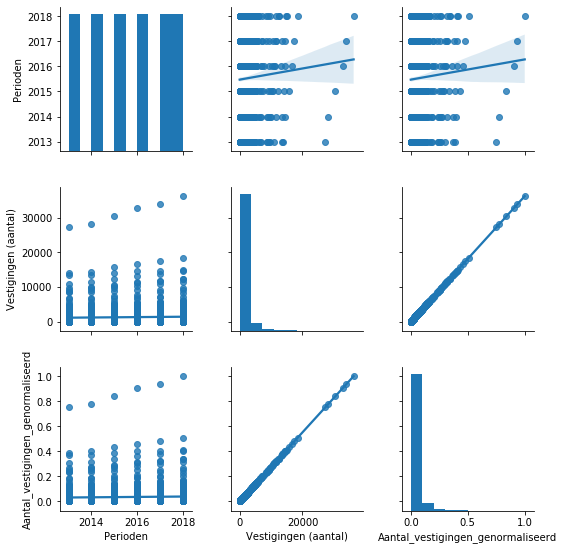

In [77]:
# In de pairplot (zie data understanding) is de voorspelde lineaire regressie nogmaals te zien in de dataset werkgelegenheid_df_lr.
sb.pairplot(werkgelegenheid_df_lr, kind="reg")

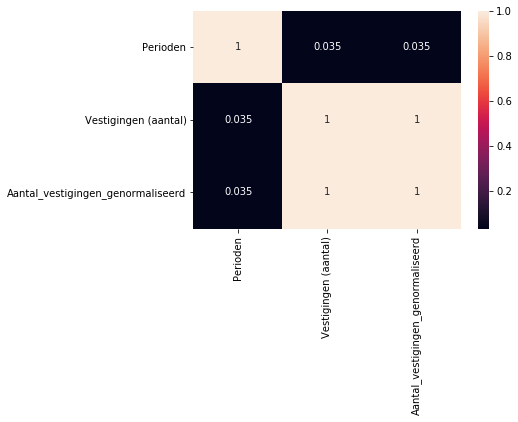

In [78]:
# In de heatmap (zie data understanding) is de voorspelde correlatie tussen de data nogmaals te zien in de dataset werkgelegenheid_df_lr.
sb.heatmap(werkgelegenheid_df_lr.corr(), annot=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002EB71836C70>,
      dtype=object)

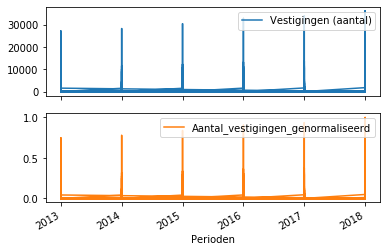

In [79]:
werkgelegenheid_df_lr.plot(subplots=True, x='Perioden')

## Hypothese
Op basis van deze bevindingen, wordt er een hypothese opgesteld dat het lineaire regressiemodel niet een bestrouwbare voorspelling kan geven, omdat de hoogste/laagste correlate te dicht bij nul ligt (0.18 en -0.082). 

## Generate Test design

Voor de lineaire regressie wordt de data gesplitst op een train en test set.

### Lineaire Regressie

In [96]:
# Het maken van een split
# Pakken van een X als waarde perioden
lr_x = werkgelegenheid_df_lr[["Perioden"]]

# Pakken van een Y als waarde Aantal vestigingen en Aantal vestigingen genormaliseerd
lr_y = werkgelegenheid_df_lr[["Vestigingen (aantal)"]] 

# create training and testing vars
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x, lr_y, test_size=0.3, random_state=56)
print("x train: ", lr_x_train.shape, "y train: ", lr_y_train.shape)
print("x test: ", lr_x_test.shape, "y test: ", lr_y_test.shape)

x train:  (1356, 1) y train:  (1356, 1)
x test:  (582, 1) y test:  (582, 1)


Er wordt een enkelvoudige regressie toegepast op de train dataset.

In [97]:
# Meervoudige regressie toepassen
reg = LinearRegression()
mreg = reg.fit(lr_x_train, lr_y_train)

r = reg.score(lr_x_test, lr_y_test)
a = reg.coef_
b = reg.intercept_

lr_y_predict = reg.predict(lr_x_test)

print("lr_y_test : ", lr_y_test, "lr_y_predict : ", lr_y_predict)

lr_y_test :        Vestigingen (aantal)
574                    370
1313                    20
1341                   570
903                    820
1880                  3625
...                    ...
92                      95
852                    745
670                    300
143                    150
1443                  1580

[582 rows x 1 columns] lr_y_predict :  [[1263.65388795]
 [1443.34785926]
 [ 994.11293099]
 [1443.34785926]
 [1173.8069023 ]
 [1263.65388795]
 [ 994.11293099]
 [1353.50087361]
 [ 994.11293099]
 [1083.95991664]
 [1173.8069023 ]
 [ 994.11293099]
 [1083.95991664]
 [1173.8069023 ]
 [1353.50087361]
 [ 994.11293099]
 [ 994.11293099]
 [1263.65388795]
 [1353.50087361]
 [ 994.11293099]
 [ 994.11293099]
 [1173.8069023 ]
 [ 994.11293099]
 [1443.34785926]
 [1353.50087361]
 [ 994.11293099]
 [1083.95991664]
 [1353.50087361]
 [1173.8069023 ]
 [1263.65388795]
 [1083.95991664]
 [1353.50087361]
 [ 994.11293099]
 [1263.65388795]
 [1083.95991664]
 [1353.50087361]
 [1353.5008

In [98]:
print("r_score : ", r)
print("a : ", a)
print("b : ", b)

r_score :  -0.005379411386510657
a :  [[89.84698566]]
b :  [-179867.86919387]


In [99]:
# Fouten bekijken van het model
print(mean_absolute_error(lr_y_test, lr_y_predict))
print(mean_squared_error(lr_y_test, lr_y_predict))
print(np.sqrt(mean_squared_error(lr_y_test, lr_y_predict)))
print(r2_score(lr_y_test, lr_y_predict))
# lm.score(x_test, y_test)

1410.3028445182126
9497695.922202684
3081.8332080439855
-0.005379411386510657


## Conclusie Lineaire Regressie
De formule van lineaire regressie zou uitkomen op 

> `y = 89,8x -179867`.

Deze formule geeft een voorspelling die niet erg betrouwbaar is. Dit komt omdat de R^2 score van deze formule 0,014 is. Hoe lager de R^2 score, hoe onbetrouwbaarder de voorspelling is.

Deze conclusie bevestigd de hypothese die eerder gesteld is, klopt dan ook. Lineaire regressie is in dit geval niet betrouwbaar om toe te passen. Dit komt waarschijnlijk doordat er bijna geen correlatie zit tussen de tijd (Perioden) en het aantal vestigingen in een regio.

## Tijdreeksanalyse

Voor tijdreeksanalyse wordt gekeken of de data stationair genoeg is om een tijdreeksanalyse toe te kunnen passen.

In [100]:
# Dataset voor tijdreeksanalyse
werkgelegenheid_df_ta = werkgelegenheid_df
print(werkgelegenheid_df_ta.columns)
print(werkgelegenheid_df_ta.info())

Index(['Provincie', 'Regio's', 'Perioden', 'Bedrijfstak_code', 'Bedrijfstak',
       'Vestigingen (aantal)', 'Aantal_vestigingen_genormaliseerd',
       'Vestigingen Klasse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincie                          1938 non-null   object 
 1   Regio's                            1938 non-null   object 
 2   Perioden                           1938 non-null   int64  
 3   Bedrijfstak_code                   1938 non-null   object 
 4   Bedrijfstak                        1938 non-null   object 
 5   Vestigingen (aantal)               1938 non-null   int64  
 6   Aantal_vestigingen_genormaliseerd  1938 non-null   float64
 7   Vestigingen Klasse                 1938 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12

In [101]:
# Dataset voor tijdreeksanalyse
werkgelegenheid_df_ta = werkgelegenheid_df[['Perioden', 'Vestigingen (aantal)']]
werkgelegenheid_df_ta

,Perioden,Vestigingen (aantal)
0,2013,65
1,2013,5
2,2013,160
3,2013,0
4,2013,10
...,...,...
1933,2018,14655
1934,2018,2910
1935,2018,5440
1936,2018,3330


In [102]:
werkgelegenheid_df_ta = werkgelegenheid_df_ta.set_index("Perioden")

Vervolgens wordt de P-waarde berekend. De P-waarde zegt iets over de stabiliteit (stationair) van de data. Als de P-waarden <0,10 is, is de data bruikbaar.

In [103]:
# Controleren of het model stabiel is of niet d.m.v. de P-waarde berekenen
from statsmodels.tsa.stattools import adfuller

result = adfuller(werkgelegenheid_df_ta.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.812655
p-value: 0.056489
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Hypothese
Dit is een P-score van onder de 0,10, wat betekend dat de data statistisch significant stabiel (stationair) is en bruikbaar is voor onze tijdreeksanalyse. De hypothese is dan dat de tijdreeksanalyse een betrouwbare voorspelling geeft over het verloop van de data.

De volgende stap is het berekenen van de ARIMA waarden, om de tijdreeksanalyse uit te kunnen voeren. Om achter de AM-waarde te komen wordt een ACF plot gebruikt, om achter de AR waarde te komen een PACF. De I waarde is standaard `1`.

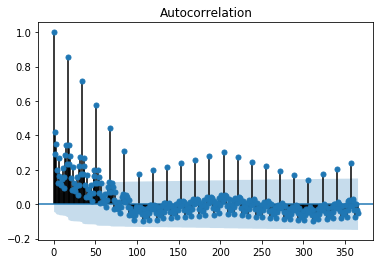

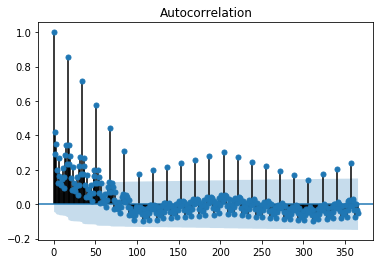

In [104]:
plot_acf(werkgelegenheid_df_ta, lags=365)

Uit deze grafiek blijkt dat de waardes niet goed binnen de blauwe zone liggen van de acf grafiek liggen. Dit betekend dat er voor de MA waarden een andere waarde dan 0 ingesteld moet worden.

We gaan proberen om met een MA waarde 1 te werken. Eerst moet ook nog een AR waarde bepaald worden.

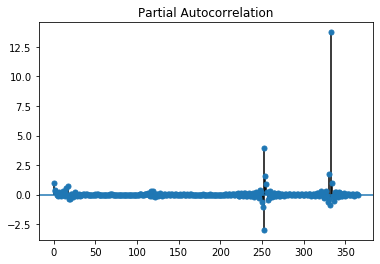

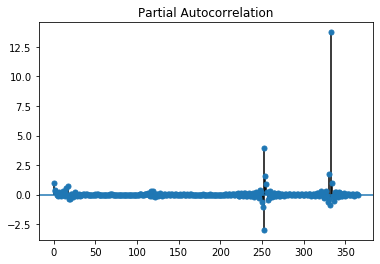

In [105]:
plot_pacf(werkgelegenheid_df_ta, lags=365)

Veruit de meeste waarden liggen rondom nul in de pacf grafiek. We gaan er daarom vanuit dat een AR waarde van 0 voor nu moet voldoen. We gaan nu met de gevonden AR en AM waarden de ARIMA functie uitvoeren. We nemen de standaard I waarde van 1.

C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
                               ARIMA Model Results                                
Dep. Variable:     D.Vestigingen (aantal)   No. Observations:                 1937
Model:                     ARIMA(0, 1, 1)   Log Likelihood              -17825.464
Method:                           css-mle   S.D. of innovations           2399.932
Date:                    Wed, 20 May 2020   AIC                          35656.928
Time:                            15:22:16   BIC                          35673.634
Sa

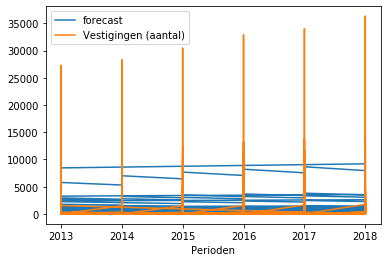

In [106]:
# ARIMA model met waarden (0, 1, 1).
werkgelegenheid_df_ta_model = ARIMA(werkgelegenheid_df_ta, order=(0, 1, 1)).fit()
print(werkgelegenheid_df_ta_model.summary())
fig = werkgelegenheid_df_ta_model.plot_predict(dynamic=False)

C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
                               ARIMA Model Results                                
Dep. Variable:     D.Vestigingen (aantal)   No. Observations:                 1937
Model:                     ARIMA(1, 1, 1)   Log Likelihood              -17824.195
Method:                           css-mle   S.D. of innovations           2398.357
Date:                    Wed, 20 May 2020   AIC                          35656.389
Time:                            15:22:17   BIC                          35678.665
Sa

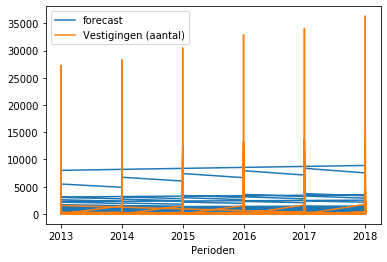

In [107]:
# ARIMA model met waarden (1, 1, 1).
werkgelegenheid_df_ta_model2 = ARIMA(werkgelegenheid_df_ta, order=(1, 1, 1)).fit()
print(werkgelegenheid_df_ta_model2.summary())
fig = werkgelegenheid_df_ta_model2.plot_predict(dynamic=False)

In [108]:
print("Voorspelde waarde: ", ARIMA(werkgelegenheid_df_ta, order=(1,1,1)).fit().predict())
print("Echte waarden: ", werkgelegenheid_df_ta["Vestigingen (aantal)"])

C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
Voorspelde waarde:  Perioden
2013        1.798920
2013       31.378509
2013      -75.238469
2013       58.955632
2013       41.087226
            ...     
2018     2023.554553
2018   -10212.214268
2018      956.488897
2018    -1354.283440
2018      617.677170
Length: 1937, dtype: float64
Echte waarden:  Perioden
2013       65
2013        5
2013      160
2013        0
2013       10
        ...  
2018    14655
2018     2910
2018     5440
2018     3330
2018        0
Name: Vestigingen (aantal), Leng

## Conclusie
In de hypothese werd gesteld dat de tijdreeksanalyse een betrouwbare voorspelling kan geven 